In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import norm

import urllib.request, json
import requests
import urllib.parse
import datetime

# Retrieve DOC Admission and Discharge Data from NYC Open Data Portal

### Socrata API urls:

* Inmate Admission: `https://data.cityofnewyork.us/resource/6teu-xtgp.json`

* Inmate Discharges: `https://data.cityofnewyork.us/resource/94ri-3ium.json`

Both of these datasets are unique on the inmate identification number `INMATEID`. We are going to count the number of inmates admitted and discharges daily from 2016 to May 1, 2023 using the SODA SQL language.

In [2]:
admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'

def get_data(url):
    query = (url+'?'
            "$select=*"
            "&$limit=500000")
    query = query.replace(" ", "%20")
    response = urllib.request.urlopen(query)
    data = json.loads(response.read())
    
    #store in dataframe
    df = pd.DataFrame(data,columns = data[0].keys())
    
    return df

In [3]:
admissions = get_data(admit_url)
admissions.head()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge
0,10008773,2018-08-23T10:15:28.000,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3
1,20037818,2018-08-05T19:13:46.000,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN
2,20197484,2018-08-14T02:08:36.000,NaN,BLACK,F,DE,120.05
3,20150289,2018-08-02T00:05:22.000,NaN,UNKNOWN,M,DPV,NaN
4,20122449,2018-08-23T18:34:24.000,NaN,UNKNOWN,M,DE,120.05


In [4]:
discharges = get_data(dis_url)
discharges.head()

,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge
0,20190778,2018-05-30T15:38:41.000,2018-08-16T06:12:04.000,UNKNOWN,M,25,CS,220.09
1,20130019,2018-02-24T20:15:24.000,2018-08-22T11:24:00.000,UNKNOWN,M,25,DE,NaN
2,41370,2018-07-30T15:58:35.000,2018-08-06T13:21:01.000,BLACK,M,49,DE,NaN
3,20035180,2018-04-30T13:34:00.000,2018-08-01T21:42:02.000,BLACK,M,49,DE,NaN
4,20115029,2018-08-31T00:39:46.000,2018-08-31T13:01:03.000,UNKNOWN,M,38,DE,NaN


In [5]:
## aggregate to monthly

admissions['admitted_dt'] = pd.to_datetime(admissions['admitted_dt'])
discharges['discharged_dt'] = pd.to_datetime(discharges['discharged_dt'])

admissions['admitted_mo'] = admissions['admitted_dt'].dt.month
discharges['discharged_mo'] = discharges['discharged_dt'].dt.month

admissions['admitted_yr'] = admissions['admitted_dt'].dt.year
discharges['discharged_yr'] = discharges['discharged_dt'].dt.year

In [6]:
admissions.head()

,inmateid,admitted_dt,discharged_dt,race,gender,inmate_status_code,top_charge,admitted_mo,admitted_yr
0,10008773,2018-08-23 10:15:28,2018-08-23T11:14:00.000,UNKNOWN,M,DE,VTL 1192.3,8,2018
1,20037818,2018-08-05 19:13:46,2018-08-10T16:46:05.000,UNKNOWN,M,DE,NaN,8,2018
2,20197484,2018-08-14 02:08:36,NaN,BLACK,F,DE,120.05,8,2018
3,20150289,2018-08-02 00:05:22,NaN,UNKNOWN,M,DPV,NaN,8,2018
4,20122449,2018-08-23 18:34:24,NaN,UNKNOWN,M,DE,120.05,8,2018


In [7]:
discharges.head()

,inmateid,admitted_dt,discharged_dt,race,gender,age,inmate_status_code,top_charge,discharged_mo,discharged_yr
0,20190778,2018-05-30T15:38:41.000,2018-08-16 06:12:04,UNKNOWN,M,25,CS,220.09,8,2018
1,20130019,2018-02-24T20:15:24.000,2018-08-22 11:24:00,UNKNOWN,M,25,DE,NaN,8,2018
2,41370,2018-07-30T15:58:35.000,2018-08-06 13:21:01,BLACK,M,49,DE,NaN,8,2018
3,20035180,2018-04-30T13:34:00.000,2018-08-01 21:42:02,BLACK,M,49,DE,NaN,8,2018
4,20115029,2018-08-31T00:39:46.000,2018-08-31 13:01:03,UNKNOWN,M,38,DE,NaN,8,2018


In [8]:
#aggregate on month and year

monthly_admits = admissions[['admitted_yr','admitted_mo','inmateid']].groupby(by = ['admitted_yr','admitted_mo']).nunique().reset_index()
monthly_admits = monthly_admits.rename(columns = {'admitted_yr':'year',
                                                'admitted_mo':'month',
                                                'inmateid':'Admissions'})
monthly_discharges = discharges[['discharged_yr','discharged_mo','inmateid']].groupby(by = ['discharged_yr','discharged_mo']).nunique().reset_index()
monthly_discharges = monthly_discharges.rename(columns = {'discharged_yr':'year',
                                                        'discharged_mo':'month',
                                                        'inmateid':'Discharges'})

#merge
monthly_counts = monthly_admits.merge(monthly_discharges, on = ['year','month'])
monthly_counts['Gain/Loss'] = monthly_counts['Admissions'] - monthly_counts['Discharges']
monthly_counts['Year-Mo'] = ['-'.join(i) for i in zip(monthly_counts["year"].map(str),monthly_counts["month"].map(str))]

monthly_counts.head()

,year,month,Admissions,Discharges,Gain/Loss,Year-Mo
0,2014,1,5954,5811,143,2014-1
1,2014,2,5232,5417,-185,2014-2
2,2014,3,6136,6061,75,2014-3
3,2014,4,5677,6005,-328,2014-4
4,2014,5,6005,6130,-125,2014-5


In [9]:
#save to csv
monthly_counts.to_csv('../Data/monthly_admit_discharge_popchange_14to23.csv')

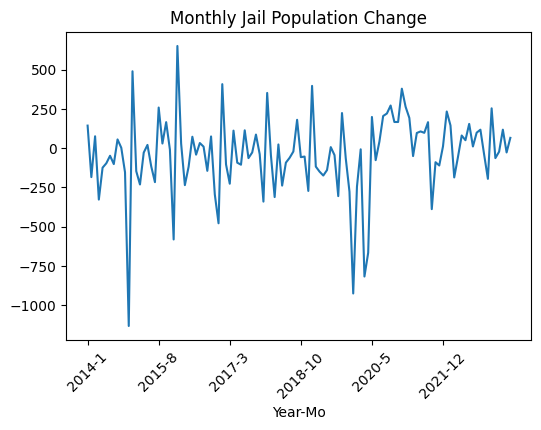

In [10]:
# Create the line plot
plt.figure(figsize = (6,4))

plt.plot(monthly_counts['Year-Mo'], monthly_counts['Gain/Loss'])

# Set the x-axis tick labels
tick_positions = range(0, len(monthly_counts['Year-Mo']), len(monthly_counts['Year-Mo'])//6)
plt.xticks(tick_positions, monthly_counts['Year-Mo'].iloc[tick_positions], rotation=45)  # Set the x-axis tick labels

plt.xlabel('Year-Mo')

# Set the y-axis label
# plt.ylabel('Gain/Loss')

# Set the plot title
plt.title('Monthly Jail Population Change')
plt.savefig('../Outputs/monthly_jailpop_change.png',bbox_inches = 'tight')
# Display the plot
plt.show()

# Conduct Time Series Analysis on Jail Population Change


### Step 1: Trend-Seasonality-Noise decomposition

### Step 2: Stationarity and Autocorrelation

In [11]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.tsa.stattools import q_stat #Compute Ljung-Box Q Statistic.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
%matplotlib inline

In [12]:
monthly_counts = monthly_counts.rename(columns = {'Gain/Loss':'Monthly Jail Population Change'})

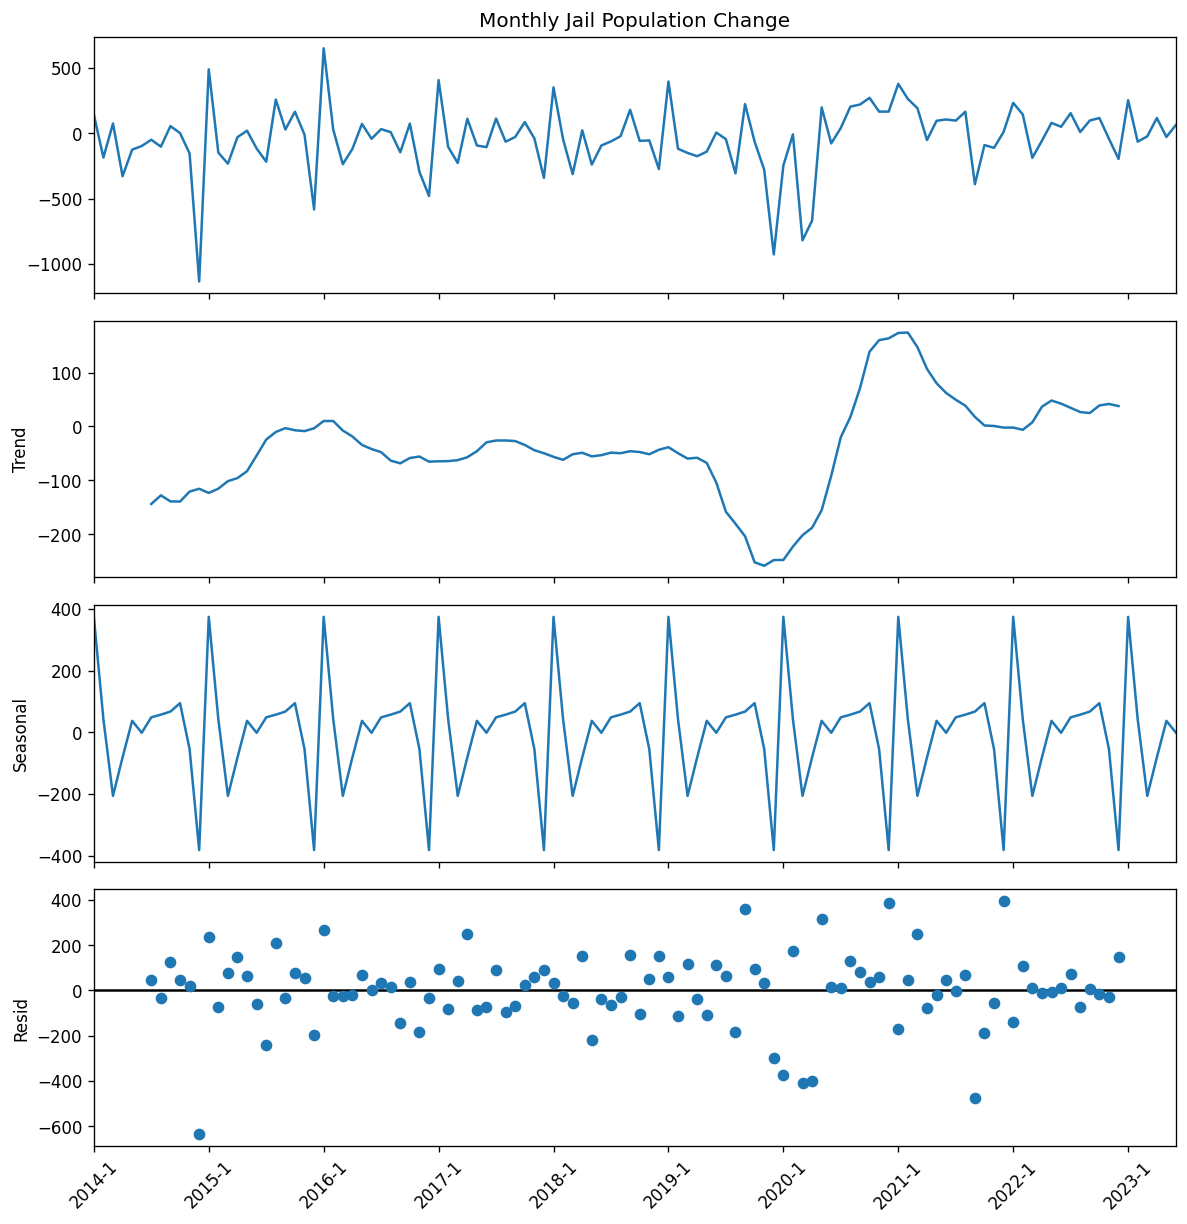

In [13]:
results = seasonal_decompose(monthly_counts['Monthly Jail Population Change'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})
# results.plot(xticks=monthly_counts['Year-Mo'].iloc[tick_positions])
results.plot()
tick_positions = range(0, len(monthly_counts), 12)
plt.xticks(tick_positions, monthly_counts['Year-Mo'].iloc[tick_positions], rotation=45)

# Save and display the plot
plt.savefig('../Outputs/pop_change_seasonal_decompose.png',bbox_inches = 'tight')
plt.show()

In [14]:
monthly_counts = monthly_counts.rename(columns = {'Monthly Jail Population Change':'Gain/Loss'})

<Figure size 960x1800 with 0 Axes>

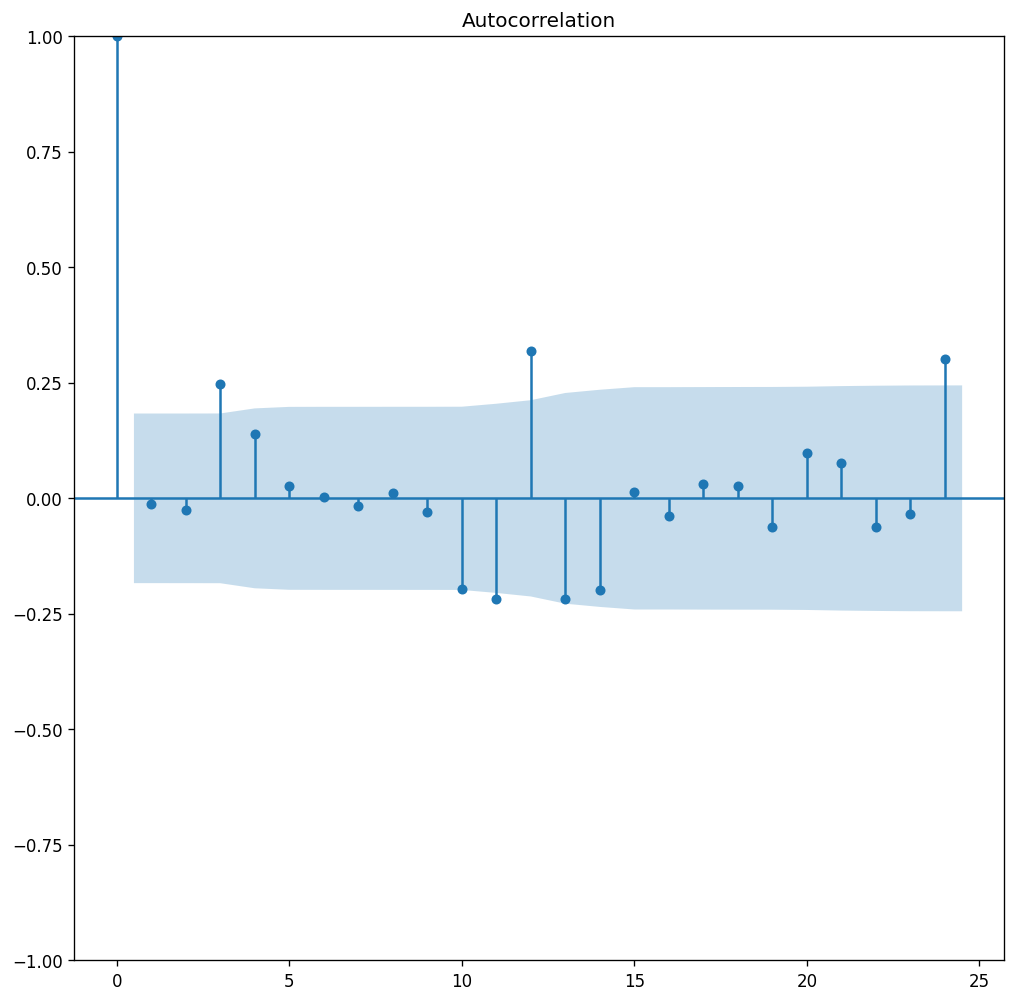

In [15]:
#plot autcorrelation for lags up to a year
plt.figure(figsize = (8,15))
plot_acf(monthly_counts['Gain/Loss'], lags = 24)
plt.show()

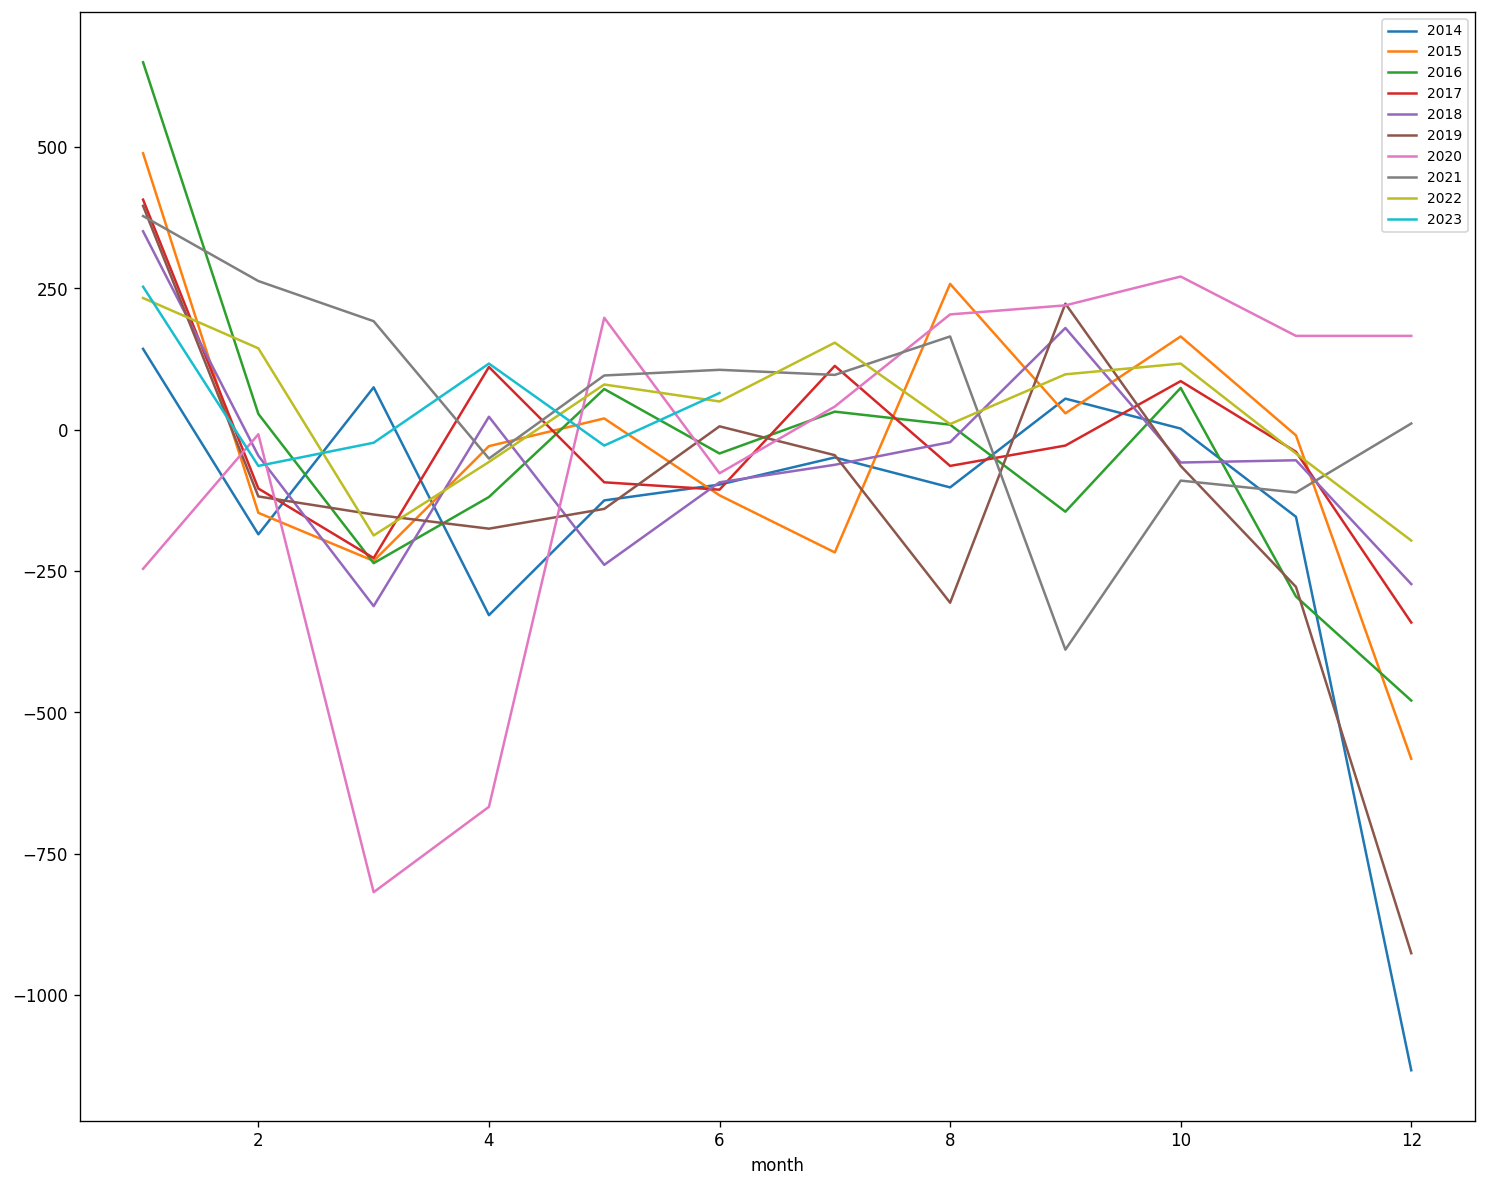

In [16]:
data_to_plot = monthly_counts.pivot(values = 'Gain/Loss',
                              index = 'month',
                              columns = 'year')
#data_to_plot
fig = plt.figure(figsize = (15, 12))
data_to_plot.plot(ax = fig.add_subplot(111))
plt.legend(loc=1, fontsize = 'small')
plt.show()


Text(0.5, 1.0, 'Partial Autocorrelation')

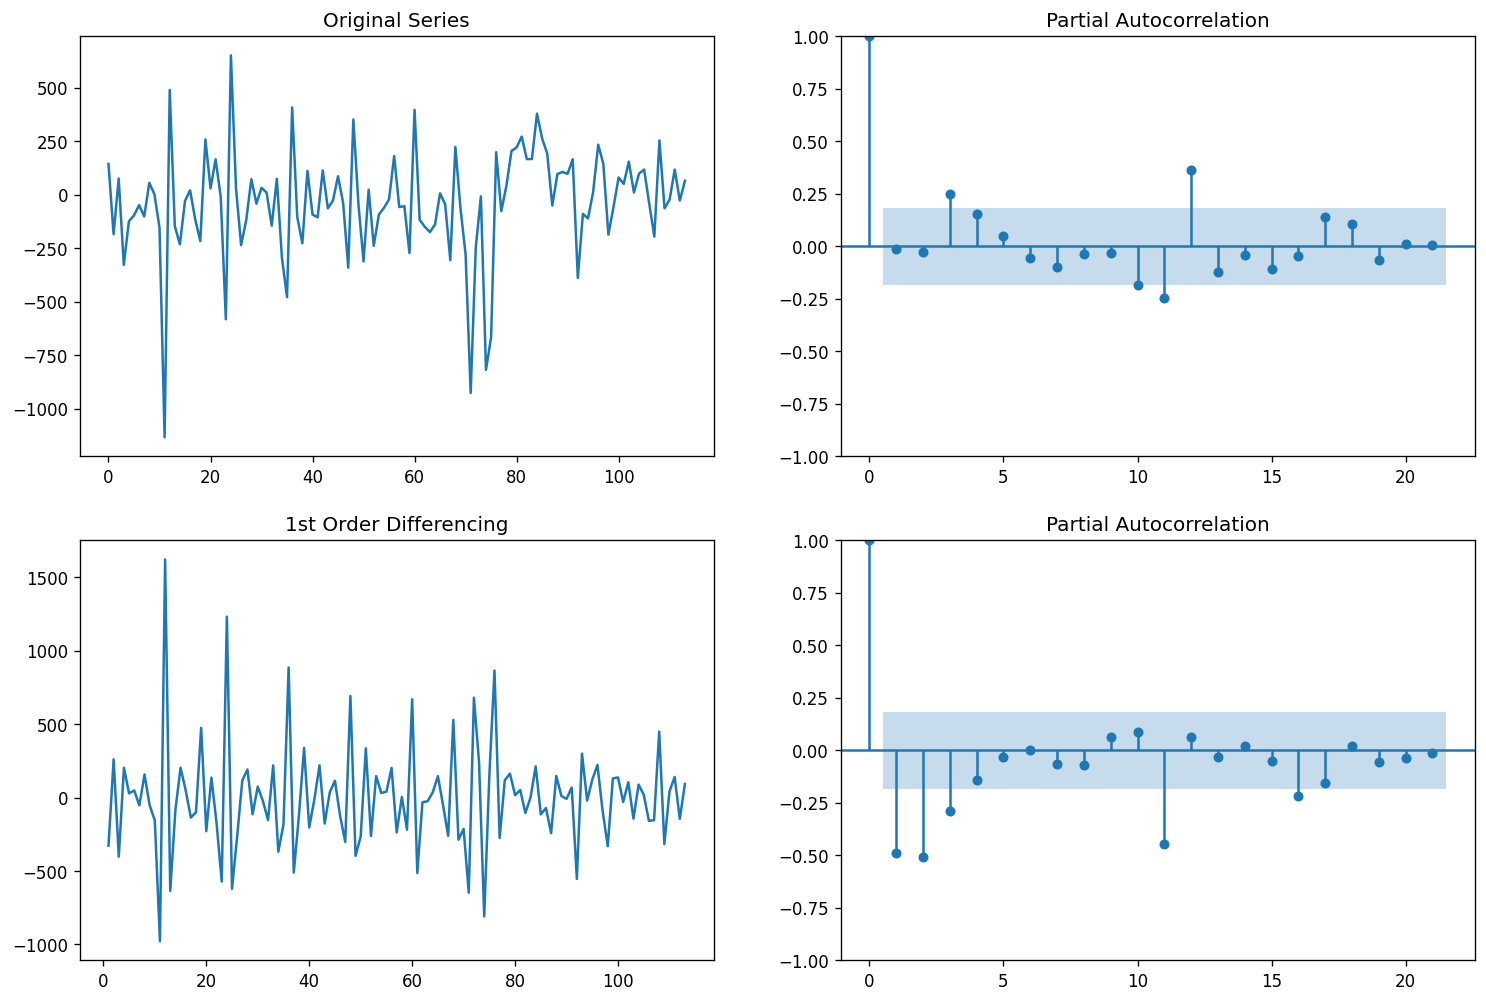

In [17]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(monthly_counts['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(monthly_counts['Gain/Loss'], ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(monthly_counts['Gain/Loss'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(monthly_counts['Gain/Loss'].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

In [18]:
result = adfuller(monthly_counts['Gain/Loss'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.860726
p-value: 0.050109
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


The population change at a monthly granualarity is not stationary. We want to difference this time series to conduct our analysis. Let's test the first order difference using an ADF test

In [19]:
result = adfuller(monthly_counts['Gain/Loss'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.173875
p-value: 0.000000
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582


### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Text(0.5, 1.0, 'Autocorrelation')

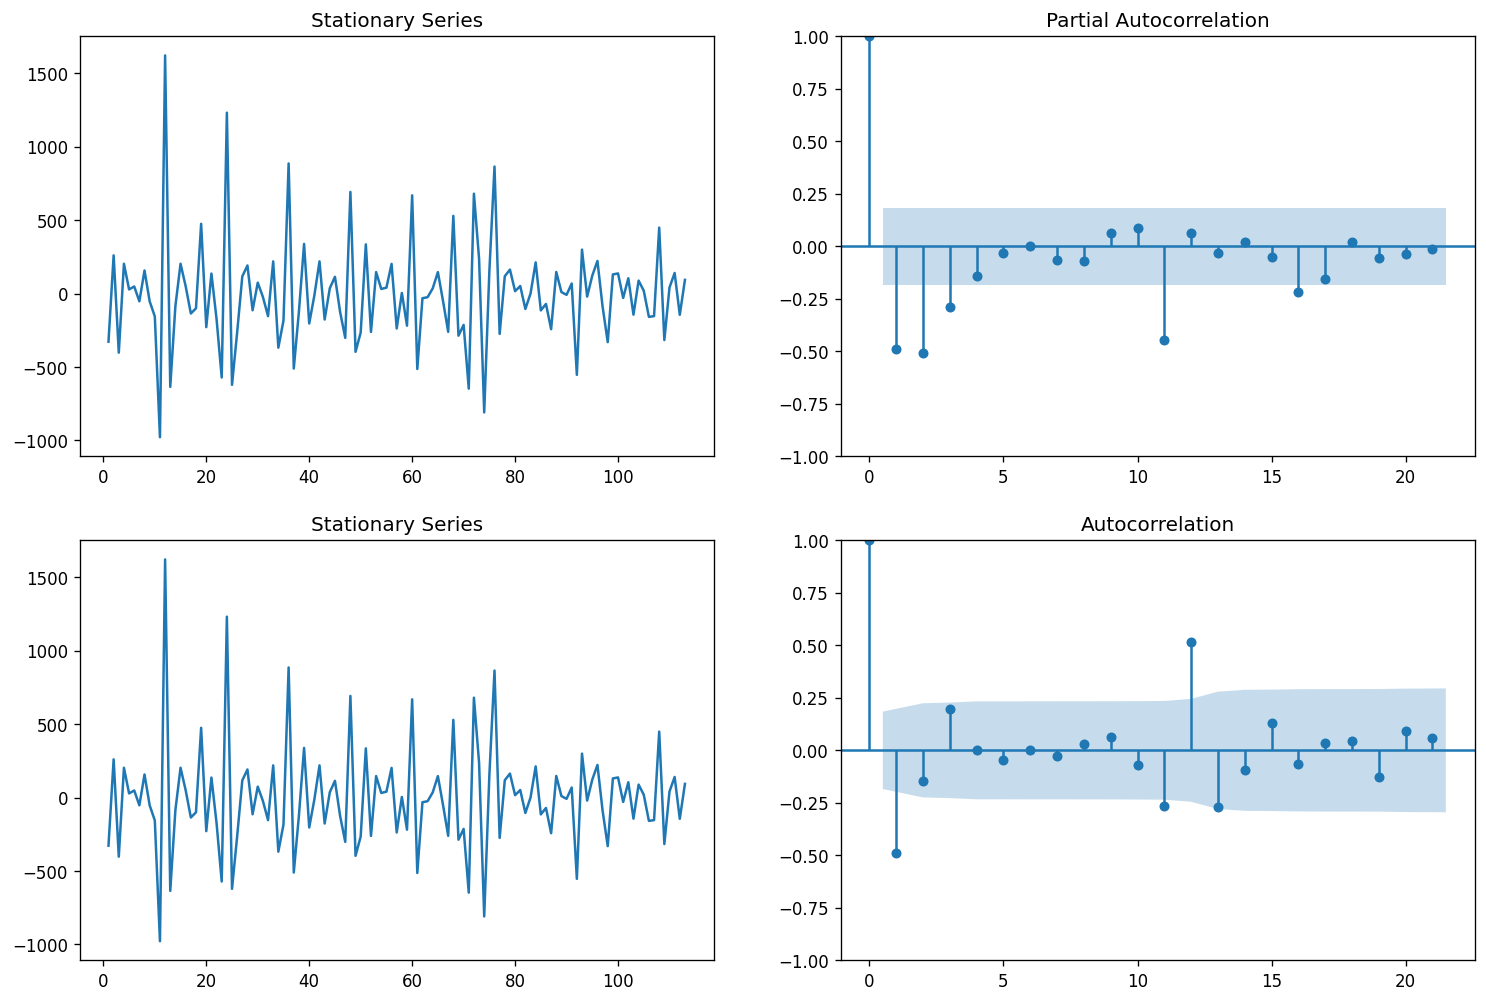

In [20]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# PACF
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(monthly_counts['Gain/Loss'].diff()); axes[0, 0].set_title('Stationary Series')

# axes[0, 0].plot(post_SHO['Gain/Loss']); axes[0, 0].set_title('Original Series')
plot_pacf(monthly_counts['Gain/Loss'].diff().dropna(), ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# ACF
axes[1, 0].plot(monthly_counts['Gain/Loss'].diff()); axes[1, 0].set_title('Stationary Series')
# axes[1, 0].plot(post_SHO['Gain/Loss']); axes[1, 0].set_title('Original Series')
plot_acf(monthly_counts['Gain/Loss'].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

Based on the above results from adfuller test, the time-series is not stationary, so we should consider ARIMA model with $d = 1$ or first-order differencing. Based on the PACF and ACF, we should consider adding a MA term of 1. Thus, lets fit an ARIMA(Q, D, P) = ARIMA(0,1,1).

Recall that:

* **p:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **q:** The number of AR terms included in the model, also called the lag order.

In [21]:
P=1
D=1
Q=0

# fit model
series = monthly_counts['Gain/Loss'].reset_index(drop = True)

model = sm.tsa.SARIMAX(series,order=(Q,D,P),seasonal_order=(Q,D,P,12))
# model = sm.tsa.ARIMA(series, order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Gain/Loss   No. Observations:                  114
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -691.578
Date:                            Mon, 10 Jul 2023   AIC                           1389.156
Time:                                    13:23:52   BIC                           1397.001
Sample:                                         0   HQIC                          1392.332
                                            - 114                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7310      0.050    -14.564      0.000      -0.829      -0.633
ma.S.L12      -0.7431      0.103   

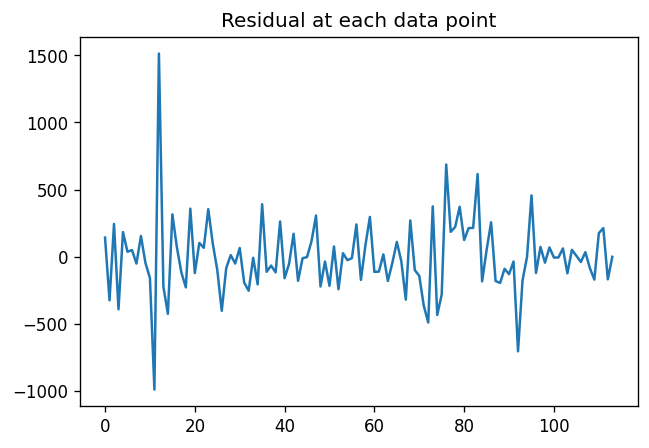

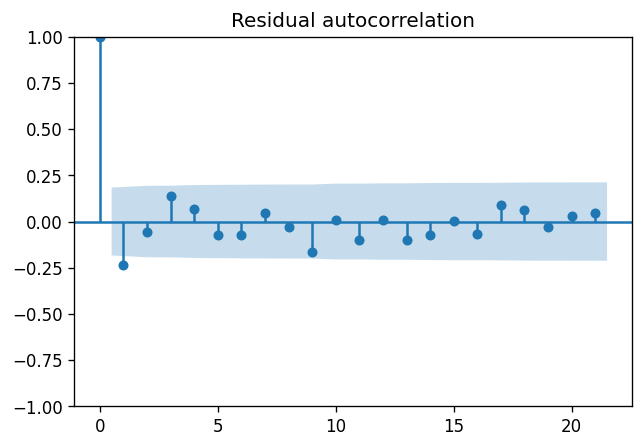

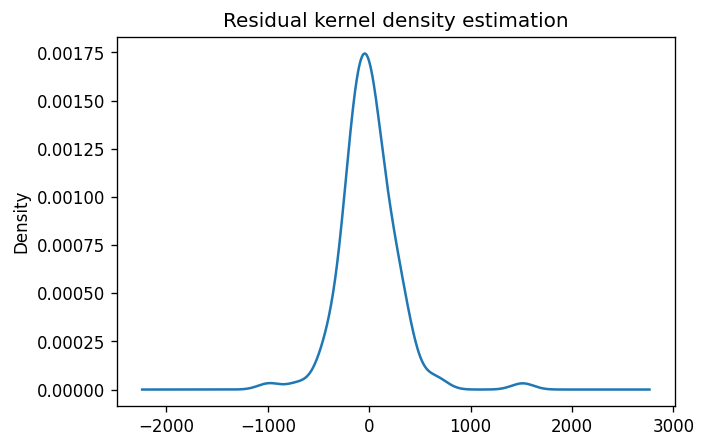

                 0
count   114.000000
mean     -3.971893
std     280.242849
min    -988.420111
25%    -159.177552
50%     -18.329115
75%     114.739721
max    1512.780898
p value is  1.4478372247270521e-10
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
      lb_stat  lb_pvalue
1    6.483534   0.010888
2    6.877839   0.032099
3    9.234267   0.026333
4    9.831606   0.043362
5   10.443931   0.063591
6   11.065243   0.086381
7   11.314458   0.125479
8   11.421410   0.178945
9   14.945169   0.092453
10  14.950841   0.133864


In [22]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

In [23]:
# Forecast
fcast = model_fit.forecast(steps = 12)  # 95% conf
fc = model_fit.get_forecast(steps = 12).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(len(series),len(series)+12))
lower_series = pd.Series(fc.mean_ci_lower, index=range(len(series),len(series)+12))
upper_series = pd.Series(fc.mean_ci_upper, index=range(len(series),len(series)+12))

In [24]:
series.tail()

109    -64
110    -23
111    117
112    -28
113     65
Name: Gain/Loss, dtype: int64

In [25]:
fc

Gain/Loss,mean,mean_se,mean_ci_lower,mean_ci_upper
114,120.531101,220.539204,-311.717796,552.779998
115,101.201880,228.381777,-346.418179,548.821938
116,84.415669,235.962685,-378.062695,546.894033
117,126.119792,243.307467,-350.754080,602.993664
118,-0.188246,250.436953,-491.035654,490.659163
119,-200.443836,257.367555,-704.874974,303.987302
120,329.393307,264.090417,-188.214400,847.001013
121,92.843752,270.667114,-437.654043,623.341548
122,-88.548048,277.087427,-631.629426,454.533330
123,-11.675268,283.362299,-567.055169,543.704633


C:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


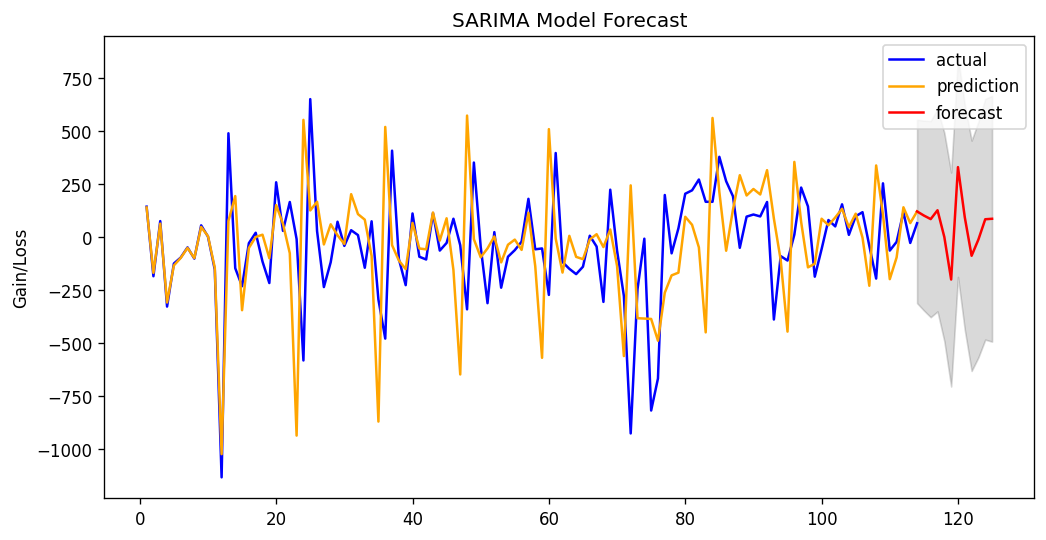

In [26]:
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index+1,series,
        color='blue',label='actual') # in-sample
ax.plot(series.index+1,model_fit.predict(start=1,end=len(series),dynamic=False,typ='levels'),
        color='orange',label='prediction') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.ylabel('Gain/Loss')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

# Hyperparameterize and Validate Results

In [27]:
monthly_counts.dtypes

year           int32
month          int32
Admissions     int64
Discharges     int64
Gain/Loss      int64
Year-Mo       object
dtype: object

In [28]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


# # Filter the data for the desired period
# start_date = '2020-05-01'
# end_date = '2022-12-31'
# train_data = monthly_counts[((monthly_counts['year'] == 2020) & (monthly_counts['month'] >= 5))|(monthly_counts['year'] == 2021)|(monthly_counts['year'] == 2022)]

# Convert the 'Year-Mo' column to datetime
monthly_counts['Year-Mo'] = pd.to_datetime(monthly_counts['Year-Mo'])
train_data = monthly_counts[monthly_counts['year'] < 2022]
test_data = monthly_counts[monthly_counts['year'] >= 2022]
# Set the 'Year-Mo' column as the index
train_data.set_index('Year-Mo', inplace=True)

# Select only the 'Gain/Loss' column for modeling
train_series = train_data['Gain/Loss']
test_series = test_data['Gain/Loss']

In [29]:
train_series[:10]

Year-Mo
2014-01-01    143
2014-02-01   -185
2014-03-01     75
2014-04-01   -328
2014-05-01   -125
2014-06-01    -97
2014-07-01    -49
2014-08-01   -102
2014-09-01     55
2014-10-01      2
Name: Gain/Loss, dtype: int64

In [30]:
# post_cvd = monthly_counts[((monthly_counts['year'] == 2020) & (monthly_counts['month'] >= 5))|(monthly_counts['year'] >= 2021)].reset_index(drop = True)
# post_cvd

In [31]:
len(train_series)

96

In [32]:
len(test_series)

18

In [33]:
# # Define the range of parameters to search
# p_values = range(0, 4)  # AutoRegressive (AR) component
# d_values = range(0, 2)  # Integrated (I) component
# q_values = range(0, 4)  # Moving Average (MA) component

# best_mse = float('inf')
# best_order = None

# # Iterate over all possible combinations of parameters
# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p, d, q)
#             if order != (0, 0, 0):  # Exclude the order (0, 0, 0)
#                 try:
#                     # Fit the ARIMA model
#                     model = ARIMA(train_series, order=order, seasonal_order = (p, d, q, 12))
#                     model_fit = model.fit(method_kwargs={'warn_convergence': False})

#                     # Perform out-of-sample forecast for 2023
#                     forecast = model_fit.get_forecast(steps=len(test_series))
#                     forecast_values = forecast.predicted_mean

#                     # Calculate the Mean Squared Error (MSE)
#                     mse = mean_squared_error(test_series, forecast_values)

#                     # Check if the current MSE is the best so far
#                     if mse < best_mse:
#                         best_mse = mse
#                         best_order = order
#                     print(order, mse)

#                 except:
#                     continue


# # Print the best parameters and corresponding MSE
# print("Best ARIMA order:", best_order)
# print("Best MSE:", best_mse)

In [34]:
# Define the range of parameters to search
# p_values = range(0, 4)  # AutoRegressive (AR) component
# d_values = range(0, 2)  # Integrated (I) component
# q_values = range(0, 4)  # Moving Average (MA) component

# best_aic = float('inf')
# best_order = None

# # Iterate over all possible combinations of parameters
# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p, d, q)
#             if order != (0, 0, 0):  # Exclude the order (0, 0, 0)
#                 try:
#                     # Fit the ARIMA model
#                     model = ARIMA(train_series, order=order, seasonal_order = (p, d, q, 12))
#                     model_fit = model.fit(method_kwargs={'warn_convergence': False})

#                     # Calculate the AIC
#                     aic = model_fit.aic

#                     # Check if the current AIC is the best so far
#                     if aic < best_aic:
#                         best_aic = aic
#                         best_order = order

#                 except:
#                     continue

# # Print the best parameters and corresponding AIC
# print("Best ARIMA order:", best_order)
# print("Best AIC:", best_aic)


In [35]:
N = len(train_series)
# order_mse = (0, 0, 5)
order_mse = (1, 1, 1)
order_aic = (0, 1, 1)
# Fit the ARIMA model
model_mse = ARIMA(train_series, order=order_mse, seasonal_order =order_mse+tuple([12]))
model_mse_fit = model_mse.fit(method_kwargs={'warn_convergence': False})

# Perform in-sample predictions
train_predictions = model_mse_fit.predict()

# Perform out-of-sample forecast for 2023
fcast_mse = model_mse_fit.forecast(steps=len(test_series))
forecast_mse = model_mse_fit.get_forecast(steps=len(test_series)).summary_frame() #get conf interval
fc_series = pd.Series(forecast_mse['mean'].values, index=range(N,len(monthly_counts)))
lower_series = pd.Series(forecast_mse.mean_ci_lower.values, index=range(N,len(monthly_counts)))
upper_series = pd.Series(forecast_mse.mean_ci_upper.values, index=range(N,len(monthly_counts)))

model_aic = ARIMA(train_series, order=order_aic, seasonal_order = order_aic+tuple([12]))
model_aic_fit = model_aic.fit(method_kwargs={'warn_convergence': False})

# Perform in-sample predictions
train_predictions_aic = model_aic_fit.predict()

# Perform out-of-sample forecast for 2023
fcast_aic = model_aic_fit.forecast(steps=len(test_series))
forecast_aic = model_aic_fit.get_forecast(steps=len(test_series)).summary_frame() #get conf interval
fc_series_aic = pd.Series(forecast_aic['mean'].values, index=range(N,len(monthly_counts)))
lower_series_aic = pd.Series(forecast_aic.mean_ci_lower.values, index=range(N,len(monthly_counts)))
upper_series_aic = pd.Series(forecast_aic.mean_ci_upper.values, index=range(N,len(monthly_counts)))

In [36]:
print(model_mse_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                        Gain/Loss   No. Observations:                   96
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -574.913
Date:                          Mon, 10 Jul 2023   AIC                           1159.827
Time:                                  13:23:53   BIC                           1171.921
Sample:                              01-01-2014   HQIC                          1164.686
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1298      0.182     -0.713      0.476      -0.487       0.227
ma.L1         -0.6111      0.128     -4.776      0.

In [37]:
print(model_aic_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                        Gain/Loss   No. Observations:                   96
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -575.291
Date:                          Mon, 10 Jul 2023   AIC                           1156.582
Time:                                  13:23:53   BIC                           1163.838
Sample:                              01-01-2014   HQIC                          1159.497
                                   - 12-01-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7030      0.065    -10.887      0.000      -0.830      -0.576
ma.S.L12      -0.6790      0.123     -5.508      0.

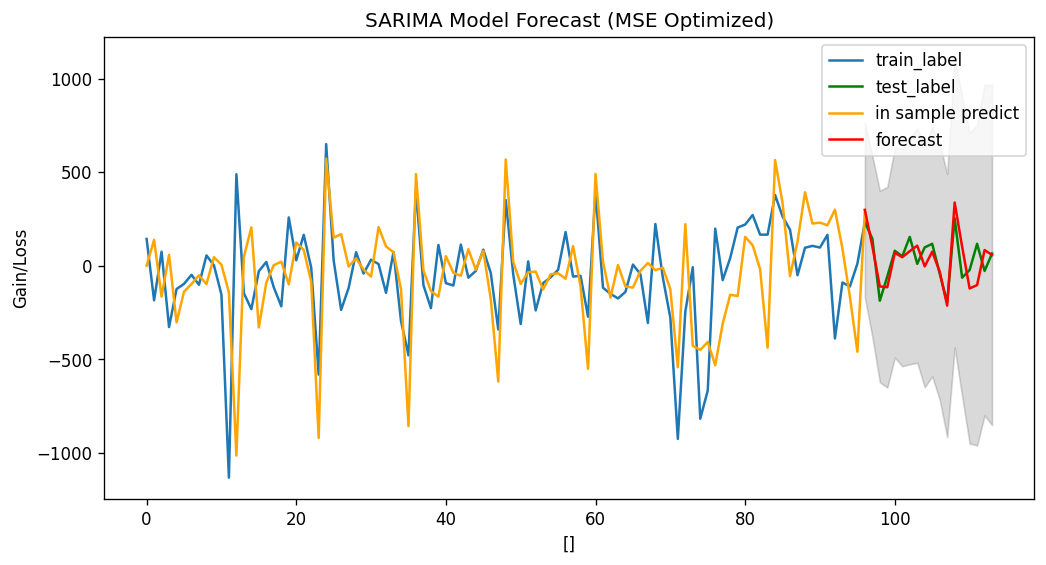

In [38]:
# Plot the data
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_counts.index[:N+1],monthly_counts[:N+1]['Gain/Loss'],label='train_label') # train
ax.plot(monthly_counts.index[N:],monthly_counts[N:]['Gain/Loss'],color='green',label='test_label') # test
ax.plot(monthly_counts.iloc[:N+1].index,model_mse_fit.predict(start=0,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(monthly_counts.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel([])
plt.ylabel('Gain/Loss')
plt.title('SARIMA Model Forecast (MSE Optimized)')
plt.legend()
plt.show()

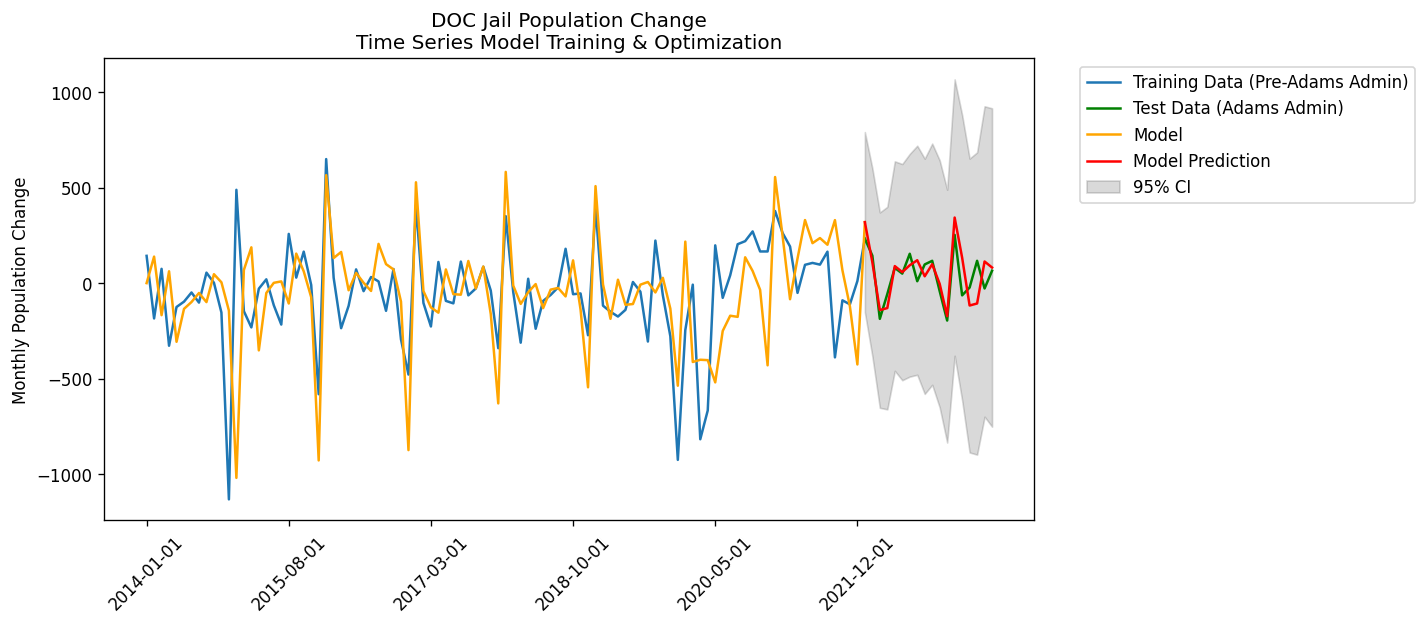

In [39]:
# Plot the data
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_counts.index[:N+1],monthly_counts[:N+1]['Gain/Loss'],label='Training Data (Pre-Adams Admin)') # train
ax.plot(monthly_counts.index[N:],monthly_counts[N:]['Gain/Loss'],color='green',label='Test Data (Adams Admin)') # test
ax.plot(monthly_counts.iloc[:N+1].index,model_aic_fit.predict(start=0,end=N,dynamic=False,typ='levels'),
        color='orange',label='Model') # in-sample
ax.plot(fc_series_aic, label='Model Prediction', color='red') # forecast
ax.fill_between(monthly_counts.iloc[N:].index, lower_series_aic, upper_series_aic, color='k', alpha=.15, label = '95% CI') # conf

plt.ylabel('Monthly Population Change')

# Extracting the x-axis values
x_values = monthly_counts['Year-Mo'].dt.strftime('%Y-%m-%d')

# Setting xticks
xticks_idx = range(0, len(x_values), len(x_values)//6)  # Calculate the indices for 7 xticks
xticks_labels = [x_values[i] for i in xticks_idx]  # Get the corresponding labels
ax.set_xticks(xticks_idx)  # Set the xtick positions
ax.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

# Adding labels, title, and legend
# ax.set_xlabel('Year-Mo')
plt.title('DOC Jail Population Change\nTime Series Model Training & Optimization')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('../Outputs/Jail_Pop_SARIMA_modelfit.png',bbox_inches = 'tight')
plt.show()

### Based on the results above, I am going to run the SARIMA(0,1,1,12) model on the entire dataset and forcast out 15 steps to Sept 2024

In [59]:
model_aic = ARIMA(monthly_counts['Gain/Loss'], order=order_aic, seasonal_order = order_aic+tuple([12]))
model_aic_fit = model_aic.fit(method_kwargs={'warn_convergence': False})

# Perform in-sample predictions
train_predictions_aic = model_aic_fit.predict()

# Perform out-of-sample forecast for 2023
fcast_aic = model_aic_fit.forecast(steps=14)
forecast_aic = model_aic_fit.get_forecast(steps=14).summary_frame() #get conf interval
fc_series_aic = pd.Series(forecast_aic['mean'].values, index=range(len(monthly_counts)-1,len(monthly_counts)+13))
lower_series_aic = pd.Series(forecast_aic.mean_ci_lower.values, index=range(len(monthly_counts)-1,len(monthly_counts)+13))
upper_series_aic = pd.Series(forecast_aic.mean_ci_upper.values, index=range(len(monthly_counts)-1,len(monthly_counts)+13))

In [60]:
forecast_aic

Gain/Loss,mean,mean_se,mean_ci_lower,mean_ci_upper
114,120.531101,220.539204,-311.717796,552.779998
115,101.201880,228.381777,-346.418179,548.821938
116,84.415669,235.962685,-378.062695,546.894033
117,126.119792,243.307467,-350.754080,602.993664
118,-0.188246,250.436953,-491.035654,490.659163
119,-200.443836,257.367555,-704.874974,303.987302
120,329.393307,264.090417,-188.214400,847.001013
121,92.843752,270.667114,-437.654043,623.341548
122,-88.548048,277.087427,-631.629426,454.533330
123,-11.675268,283.362299,-567.055169,543.704633


In [61]:
monthly_counts.tail()

,year,month,Admissions,Discharges,Gain/Loss,Year-Mo
109,2023,2,1620,1684,-64,2023-02-01
110,2023,3,1836,1859,-23,2023-03-01
111,2023,4,1828,1711,117,2023-04-01
112,2023,5,1903,1931,-28,2023-05-01
113,2023,6,1963,1898,65,2023-06-01


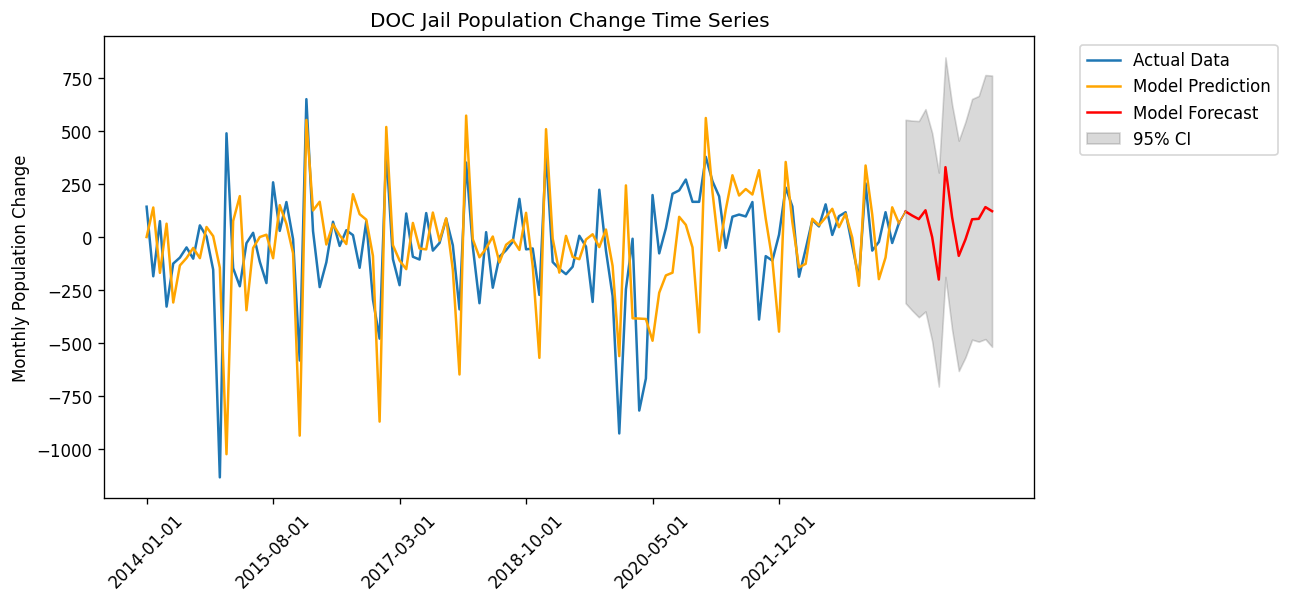

In [62]:
# Plot the data
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(monthly_counts.index,monthly_counts['Gain/Loss'],label='Actual Data') # train
ax.plot(monthly_counts.index,model_aic_fit.predict(start=0,end=len(monthly_counts)-1,dynamic=False,typ='levels'),
        color='orange',label='Model Prediction') # in-sample
ax.plot(fcast_aic.index,fc_series_aic, label='Model Forecast', color='red') # forecast
ax.fill_between(fcast_aic.index, lower_series_aic, upper_series_aic, color='k', alpha=.15, label = '95% CI') # conf

plt.ylabel('Monthly Population Change')

# Extracting the x-axis values
x_values = monthly_counts['Year-Mo'].dt.strftime('%Y-%m-%d')

# Setting xticks
xticks_idx = range(0, len(x_values), len(x_values)//6)  # Calculate the indices for 7 xticks
xticks_labels = [x_values[i] for i in xticks_idx]  # Get the corresponding labels
ax.set_xticks(xticks_idx)  # Set the xtick positions
ax.set_xticklabels(xticks_labels, rotation=45)  # Set the xtick labels with rotation

# Connect train_label and in sample predict to forecast
ax.plot([monthly_counts.index[-1], fcast_aic.index[0]], [monthly_counts['Gain/Loss'].iloc[-1], fc_series_aic.iloc[0]],
        color='blue',linewidth = 1)
ax.plot([monthly_counts.index[-1], fcast_aic.index[0]], [list(model_aic_fit.predict(start=0, end=len(monthly_counts)-1, dynamic=False, typ='levels'))[-1], fc_series_aic.iloc[0]],
        color='orange',linewidth = 1)
# Adding labels, title, and legend
# ax.set_xlabel('Year-Mo')
plt.title('DOC Jail Population Change Time Series')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.savefig('../Outputs/Jail_Pop_SARIMA_model_forecast.png',bbox_inches = 'tight')
plt.show()

### Based on the forecast summary frame, lets construct 15 different distributions to sample from at random and compute the Projected Jail Population

As of May 31th, 2023 the average DOC Daily Jail Population was 6,049 people. 

Based on the forecasted values means and standard error, we can construct 15 individual distributions (assuming they come from a normal distribution) and sample from each distribution X # of times to find the probability in which the jail population will exceed 7,000 by September 2024. 

In [63]:
forecast_aic

Gain/Loss,mean,mean_se,mean_ci_lower,mean_ci_upper
114,120.531101,220.539204,-311.717796,552.779998
115,101.201880,228.381777,-346.418179,548.821938
116,84.415669,235.962685,-378.062695,546.894033
117,126.119792,243.307467,-350.754080,602.993664
118,-0.188246,250.436953,-491.035654,490.659163
119,-200.443836,257.367555,-704.874974,303.987302
120,329.393307,264.090417,-188.214400,847.001013
121,92.843752,270.667114,-437.654043,623.341548
122,-88.548048,277.087427,-631.629426,454.533330
123,-11.675268,283.362299,-567.055169,543.704633


In [64]:
steps = np.arange(114,128)

# Construct distribution function for each step
distributions = []
for i in steps:
    mean = forecast_aic['mean'][i]
    se = forecast_aic['mean_se'][i]
    lower = forecast_aic['mean_ci_lower'][i]
    upper = forecast_aic['mean_ci_upper'][i]
    
    # Calculate the standard deviation from the standard error
    std = se / np.sqrt(1)  # Assuming you have 1 observation for each step
    
    # Adjust the bounds based on confidence intervals
    lower_adj = max(lower, mean - 1.96 * std)  # 1.96 corresponds to a 95% confidence interval
    upper_adj = min(upper, mean + 1.96 * std)
    
    # Create a normal distribution using the adjusted mean and standard deviation
    dist = np.random.normal(loc=mean, scale=std, size=100000)
    
    # Clip the distribution within the adjusted bounds
#     dist = np.clip(dist, lower_adj, upper_adj)
    
    distributions.append(dist)

In [65]:
# Create a list of column labels
start_date = pd.to_datetime("2023-07", format="%Y-%m")
column_labels = [start_date + pd.offsets.DateOffset(months=i) for i in range(14)]
column_labels = [label.strftime("%Y-%m") for label in column_labels]

# Create a DataFrame with random samples
random_forecast_samps = pd.DataFrame(distributions).T

# Set the column labels
random_forecast_samps.columns = column_labels

# Display the DataFrame
random_forecast_samps.head()

,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08
0,321.387877,428.489526,208.841515,42.866281,255.348245,187.172204,614.683304,579.202884,-125.784549,160.680056,127.065205,269.117671,279.741712,-267.464412
1,-13.732570,192.532886,-108.483252,195.127414,-16.960000,-275.821798,234.088988,67.460018,57.000881,-388.849578,-276.817305,243.277904,108.526802,58.378788
2,224.752050,473.192051,-43.603791,-8.032593,42.158033,-166.624885,296.429635,124.190335,268.377109,-600.713459,676.140523,257.521763,452.337589,45.846067
3,114.906347,-213.073790,-199.028512,225.197466,-422.275063,379.220058,456.239987,286.991333,186.850696,-38.241280,291.362687,-409.296714,1035.096284,-8.107255
4,-170.104598,317.303755,9.167063,188.956540,-293.641579,-389.971851,191.367890,71.829133,176.424051,302.508415,243.888642,292.894684,192.782674,723.855925


In [66]:
#daily jail pop as of May 31, 2023 is 6,016
random_forecast_samps['Proj_Pop'] = random_forecast_samps.sum(axis=1) + 6050

In [67]:
random_forecast_samps.describe()

,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,Proj_Pop
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,120.603346,101.292946,84.770993,125.428149,-0.201084,-199.275133,329.829009,93.546002,-87.698172,-11.963761,83.878441,86.727104,141.037585,124.231776,7042.207201
std,220.332043,229.211193,236.652538,243.594629,250.788095,257.379227,264.209815,271.247292,277.328447,284.084144,290.123886,295.429129,317.504927,325.554660,1012.912419
min,-855.459829,-859.724894,-934.142481,-980.366113,-1065.379891,-1244.891046,-745.087958,-1089.118610,-1304.755268,-1315.459507,-1079.586172,-1170.636429,-1325.019578,-1253.469155,2772.389169
25%,-27.688430,-54.050931,-75.597120,-39.209368,-170.082035,-373.521679,151.886132,-90.168245,-275.821318,-203.650366,-113.354960,-112.510215,-72.930121,-96.534112,6356.517490
50%,120.758615,101.547800,84.493742,125.744649,-0.265707,-198.987332,328.214522,94.365875,-87.510001,-12.081578,83.289960,86.494731,140.590497,123.746597,7042.261629
75%,269.844280,255.886580,245.309132,289.080520,168.954264,-25.105083,508.040004,277.062723,99.957007,179.357378,279.562574,287.089697,355.085890,344.201626,7724.239530
max,1110.123472,1237.681892,1135.065641,1183.042380,1135.144916,956.025249,1446.613715,1227.010791,1233.433214,1156.598102,1372.469256,1331.086610,1481.049649,1646.423049,11384.669885


In [68]:
#what is the probability this number is greater than or equal to 7,000
len(random_forecast_samps['Proj_Pop'][random_forecast_samps['Proj_Pop']>= 7000])/len(random_forecast_samps['Proj_Pop'])*100

51.641999999999996

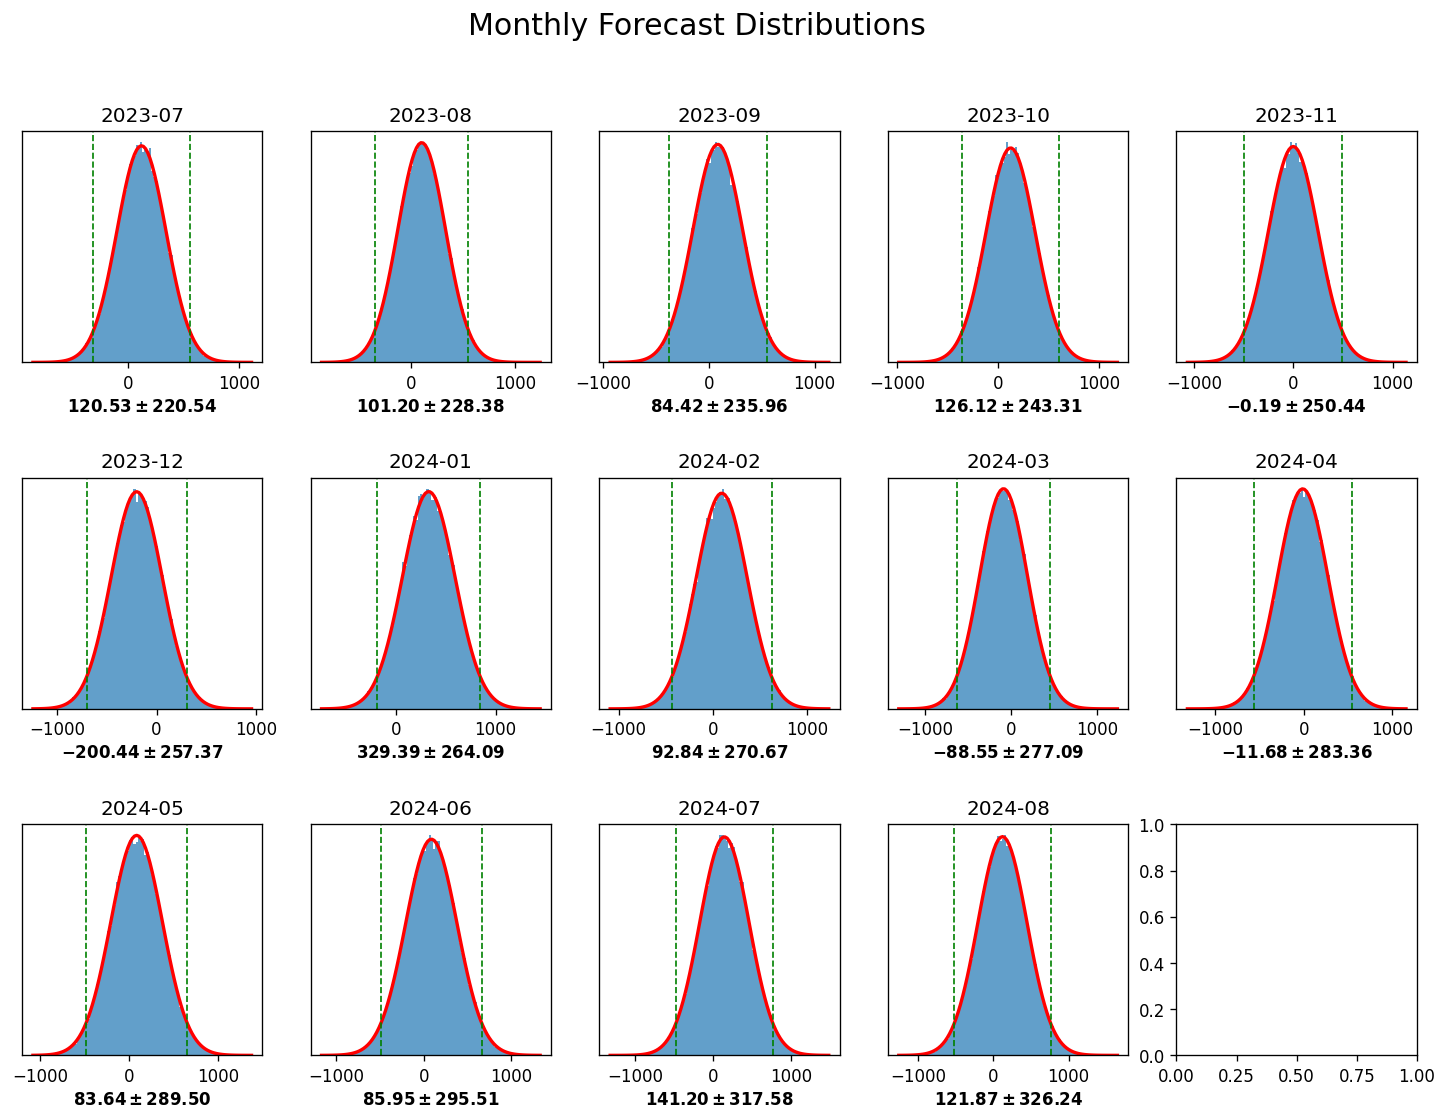

In [69]:
# Create a list of month names for subplot titles
months = list(random_forecast_samps.columns)

# Set up the figure with 15 subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Flatten the subplot array
axs = axs.flatten()

# Iterate over each month and create a histogram with the corresponding line
for i, month in enumerate(months[:-1]):
    # Plot histogram
    axs[i].hist(random_forecast_samps[month], bins=100, density=True, alpha=0.7)

    # Plot line
    mean = forecast_aic.loc[i + 114, 'mean']
    mean_se = forecast_aic.loc[i + 114, 'mean_se']
    x = np.linspace(
        random_forecast_samps[month].min(),
        random_forecast_samps[month].max(),
        100
    )
    y = norm.pdf(x, mean, mean_se)
    axs[i].plot(x, y, color='red', linewidth=2)
    
    # Add vertical lines for confidence intervals
    ci_lower = forecast_aic.loc[i + 114, 'mean_ci_lower']
    ci_upper = forecast_aic.loc[i + 114, 'mean_ci_upper']
    axs[i].axvline(ci_lower, color='green', linestyle='--', linewidth=1)
    axs[i].axvline(ci_upper, color='green', linestyle='--', linewidth=1)

    # Remove y-axis ticks
    axs[i].set_yticks([])

    # Add text for mean value
    mean_text = r'$\mathbf{{ {:.2f} \pm {:.2f} }}$'.format(mean,mean_se)
    axs[i].text(0.5, -0.15, mean_text, transform=axs[i].transAxes, ha='center', va='top', fontsize=10)
    # Set subplot title
    axs[i].set_title(month)

# Remove empty subplots
for j in range(len(months), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Monthly Forecast Distributions', fontsize=18)
# plt.savefig('../Outputs/Monthly_Jail_Pop_forecast_distributions.png',bbox_inches = 'tight')
# Display the figure
plt.show()

In [70]:
#get the 95% CI for the mean Projected Population
# Calculate the sample mean and standard deviation
sample_mean = random_forecast_samps['Proj_Pop'].mean()
sample_std = random_forecast_samps['Proj_Pop'].std()

# Calculate the confidence interval 
#1.96 for 95% CI
lower_bound_95 = sample_mean - 1.96*sample_std
upper_bound_95 = sample_mean + 1.96*sample_std
#1.64 for 90% CI
lower_bound_90 = sample_mean - 1.64*sample_std
upper_bound_90 = sample_mean + 1.64*sample_std
#1.28 for 80% CI
lower_bound_80 = sample_mean - 1.28*sample_std
upper_bound_80 = sample_mean + 1.28*sample_std

# Display the confidence interval
print(f"95% Confidence Interval: [{lower_bound_95}, {upper_bound_95}]")
print(f"90% Confidence Interval: [{lower_bound_90}, {upper_bound_90}]")
print(f"80% Confidence Interval: [{lower_bound_80}, {upper_bound_80}]")

95% Confidence Interval: [5056.898859837535, 9027.515541862364]
90% Confidence Interval: [5381.030833880379, 8703.38356781952]
80% Confidence Interval: [5745.679304678577, 8338.735097021321]


In [71]:
#what is the probability this number is greater than or equal to 7,000 but below the upper bound of the 95% CI
len(random_forecast_samps['Proj_Pop'][(random_forecast_samps['Proj_Pop']>= 7000)&(random_forecast_samps['Proj_Pop']<= upper_bound_95)])/len(random_forecast_samps['Proj_Pop'])*100

49.122

In [72]:
#what is the probability this number is below May 31, 2023 jail population
len(random_forecast_samps['Proj_Pop'][(random_forecast_samps['Proj_Pop']<= 6016)&(random_forecast_samps['Proj_Pop']>= lower_bound_95)])/len(random_forecast_samps['Proj_Pop'])*100

12.909

In [73]:
#what is the probability this number is below May 31, 2023 jail population
len(random_forecast_samps['Proj_Pop'][(random_forecast_samps['Proj_Pop']<= 6049)])/len(random_forecast_samps['Proj_Pop'])*100

16.198

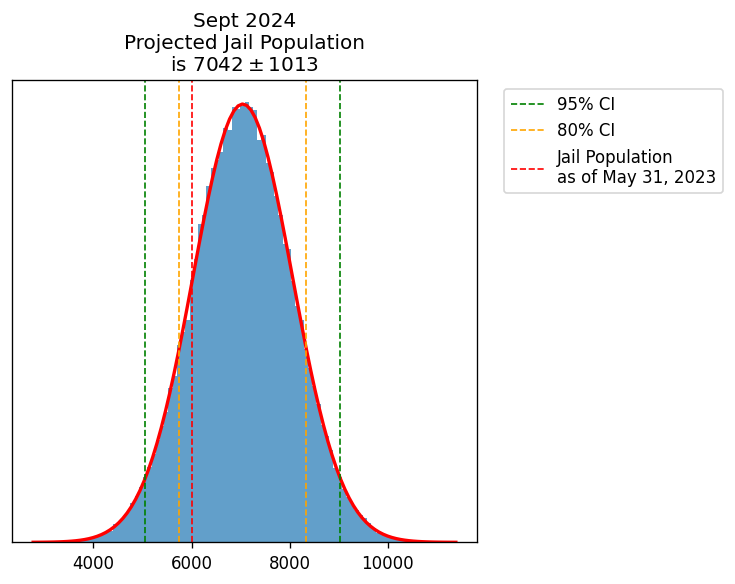

In [74]:
# Plot histogram
fig, axs = plt.subplots(figsize=(5, 5))

axs.hist(random_forecast_samps['Proj_Pop'], bins=100, density=True, alpha=0.7)

# Plot line

x = np.linspace(
    random_forecast_samps['Proj_Pop'].min(),
    random_forecast_samps['Proj_Pop'].max(),
    100
)
y = norm.pdf(x, sample_mean, sample_std)
axs.plot(x, y, color='red', linewidth=2)

# Add vertical lines for confidence intervals
axs.axvline(lower_bound_95, color='green', linestyle='--', linewidth=1)
axs.axvline(upper_bound_95, color='green', linestyle='--', linewidth=1,label = '95% CI')

axs.axvline(lower_bound_80, color='orange', linestyle='--', linewidth=1)
axs.axvline(upper_bound_80, color='orange', linestyle='--', linewidth=1,label = '80% CI')

axs.axvline(6016, color='red', linestyle='--', linewidth=1,label = 'Jail Population\nas of May 31, 2023')

# Remove y-axis ticks
axs.set_yticks([])

# Add text for mean value
mean_text = 'Sept 2024\nProjected Jail Population\nis ${:0.0f} \pm {:0.0f}$'.format(sample_mean,sample_std)
# axs.text(0.2, 0.95, mean_text, transform=axs.transAxes, ha='center', va='top', fontsize=10, fontweight = 'bold')
# Set subplot title
axs.set_title(mean_text)
axs.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.savefig('../Outputs/sept24_mean_population_forecast.png',bbox_inches = 'tight')
plt.show()